In [ ]:
!pip install numpy pandas matplotlib seaborn tensorflow==2.9.0 scikit-learn xgboost

In [6]:
import os  # for getting environment variables
import pathlib # for finding the example dataset
import numpy as np
import tensorflow as tf
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt
import pytz
import matplotlib.dates as mdates# for visualization
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import csv
from google.colab import drive
import io
import re
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

In [ ]:
#Scrapping the data
# import requests
# import csv
# from io import StringIO

# url = "https://midcdmz.nrel.gov/apps/plot.pl?site=ORNL;start=20070912;edy=20;emo=11;eyr=2019;year=2017;month=1;day=1;time=1;inst=3;inst=7;inst=8;inst=9;inst=10;inst=11;inst=12;inst=13;inst=14;type=data;first=3;math=0;second=-1;value=0.0;user=0;axis=1;endyear=2017;endmonth=12;endday=31"

# response = requests.get(url)

# if response.status_code == 200:
#     # Parse the response as CSV and save it to a file
#     csv_data = response.text
#     csv_file = csv.reader(StringIO(csv_data))

#     # Specify the path where you want to save the CSV file
#     csv_file_path = "output_data.csv"

#     # Write the CSV data to the file
#     with open(csv_file_path, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         for row in csv_file:
#             writer.writerow(row)

#     print(f"Data successfully retrieved and saved to {csv_file_path}")
# else:
#     print(f"Failed to retrieve data. Status code: {response.status_code}")




In [10]:
# Mount Google Drive
drive.mount('/content/drive')
# Load the combined dataset
file_path = '/content/drive/MyDrive/nrel_solar_irradiance_data_2016_2019_combined.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df = pd.read_csv(file_path)

In [12]:
# Convert the 'DATE (MM/DD/YYYY)' column to datetime format
df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format="%m/%d/%Y")

# Drop rows with NaN values in the 'EST' column
df.dropna(subset=['EST'], inplace=True)  # Drop rows with NaN values in 'EST'

# Extract hour and minute components from the 'EST' column and create new columns
df[['Hour', 'Minute']] = df['EST'].str.extract('(\d+):(\d+)', expand=True)

# Convert the hour and minute components to integers
df[['Hour', 'Minute']] = df[['Hour', 'Minute']].astype(int)

# Create a timedelta column using the hour and minute components
df['Timedelta'] = pd.to_timedelta(df['Hour'], unit='h') + pd.to_timedelta(df['Minute'], unit='m')

# Combine the date with the timedelta to get a complete datetime
df['Datetime'] = df['DATE (MM/DD/YYYY)'] + df['Timedelta']

# Set the Datetime column as the index
df.set_index('Datetime', inplace=True)

In [ ]:
# Handle negative Global Horizontal values
negative_gh = df[df['Global Horizontal [W/m^2]'] < 0]
print(f"\nNumber of records with negative Global Horizontal: {len(negative_gh)}")

if len(negative_gh) > 0:
    print("\nNegative Global Horizontal records:")
    print(negative_gh)


    # Handle negative values
    # Option 1: Set negative values to 0
    df.loc[df['Global Horizontal [W/m^2]'] < 0, 'Global Horizontal [W/m^2]'] = 0

    # Option 2: Interpolate negative values
    # df.loc[df['Global Horizontal [W/m^2]'] < 0, 'Global Horizontal [W/m^2]'] = np.nan
    # df['Global Horizontal [W/m^2]'] = df['Global Horizontal [W/m^2]'].interpolate()

    print("\nAfter handling negative values:")
    print(f"Number of records with negative Global Horizontal: {len(df[df['Global Horizontal [W/m^2]'] < 0])}")

In [14]:
"""Create new columns Wind_North and Wind_South from the wind direction"""

# Create new columns for binary representation of wind direction
df['Wind_North'] = (df['Avg Wind Direction @ 42ft [deg from N]'] >= 315) | (df['Avg Wind Direction @ 42ft [deg from N]'] < 45)
df['Wind_South'] = (df['Avg Wind Direction @ 42ft [deg from N]'] >= 135) & (df['Avg Wind Direction @ 42ft [deg from N]'] < 225)

# Convert boolean values to 0 and 1
df['Wind_North'] = df['Wind_North'].astype(int)
df['Wind_South'] = df['Wind_South'].astype(int)

#drop the original column.
df.drop('Avg Wind Direction @ 42ft [deg from N]', axis=1, inplace=True)

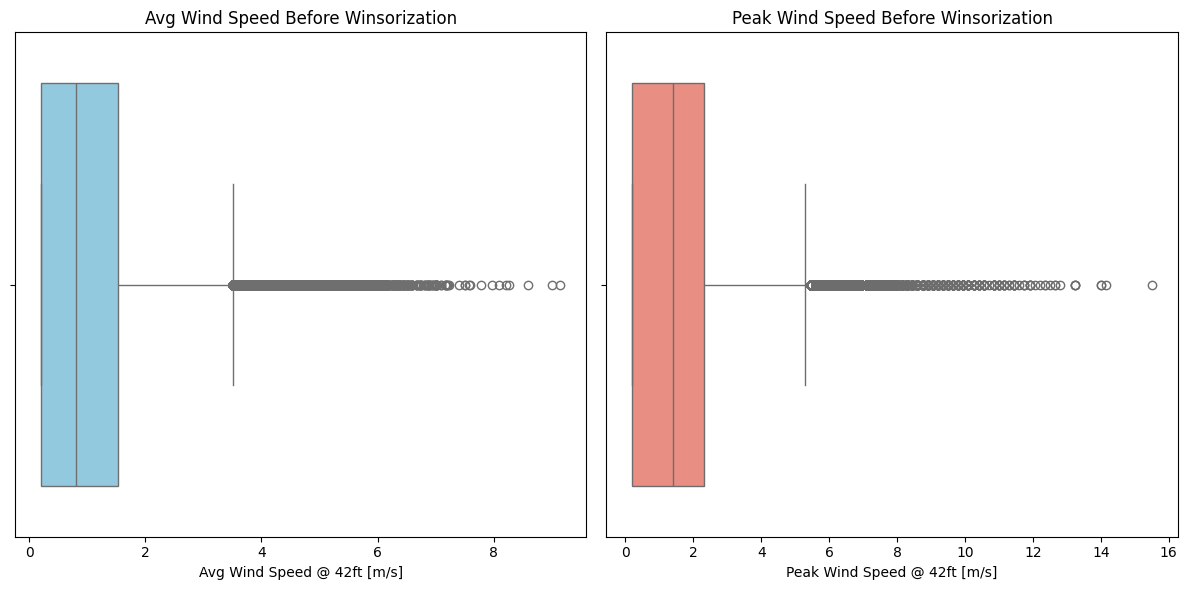

In [ ]:
# # Box plot for Avg Wind Speed @ 42ft [m/s] before winsorization
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.boxplot(data=df, x='Avg Wind Speed @ 42ft [m/s]', color='skyblue')
# plt.title('Avg Wind Speed Before Winsorization')

# # Box plot for Peak Wind Speed @ 42ft [m/s] before winsorization
# plt.subplot(1, 2, 2)
# sns.boxplot(data=df, x='Peak Wind Speed @ 42ft [m/s]', color='salmon')
# plt.title('Peak Wind Speed Before Winsorization')

# plt.tight_layout()
# plt.show()

In [15]:
# List of features with outliers to be winsorized
features_with_outliers = ['Avg Wind Speed @ 42ft [m/s]', 'Peak Wind Speed @ 42ft [m/s]']

features_to_normalize = ['Air Temperature [deg C]', 'Rel Humidity [%]', 'Est Pressure [mBar]',
                          'Precipitation [mm]', 'Precipitation (Accumulated) [mm]']

# Apply winsorization to selected features to handle outliers by clipping extreme values.
for feature in features_with_outliers:
    df[feature] = winsorize(df[feature], limits=[0.05, 0.05])

# Apply normalization to scale all features to a similar range (between 0 and 1.)
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Standardize the mixed-feature dataset
mixed_features = features_with_outliers + features_to_normalize
scaler_standardize = StandardScaler()
df[mixed_features] = scaler_standardize.fit_transform(df[mixed_features])


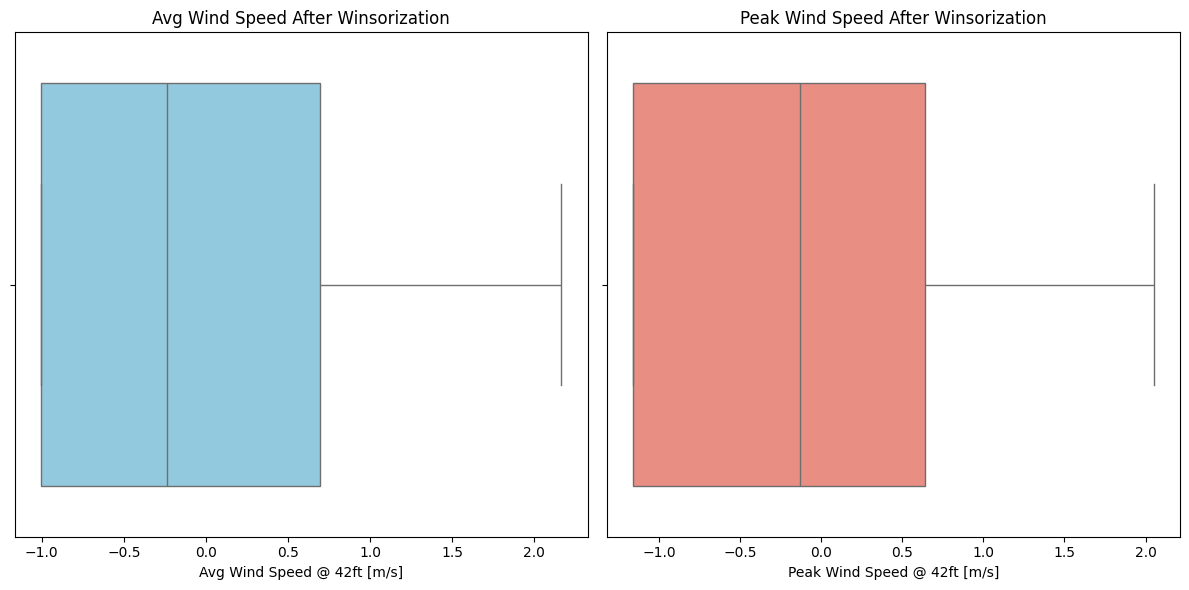

In [ ]:
# # Box plot for Avg Wind Speed @ 42ft [m/s] after winsorization
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# sns.boxplot(data=df, x='Avg Wind Speed @ 42ft [m/s]', color='skyblue')
# plt.title('Avg Wind Speed After Winsorization')

# # Box plot for Peak Wind Speed @ 42ft [m/s] after winsorization
# plt.subplot(1, 2, 2)
# sns.boxplot(data=df, x='Peak Wind Speed @ 42ft [m/s]', color='salmon')
# plt.title('Peak Wind Speed After Winsorization')

# plt.tight_layout()
# plt.show()


In [16]:
def create_cyclical_features(df):
    """
    Create cyclical time features from datetime information.
    """
    # Ensure 'DATE (MM/DD/YYYY)' is in datetime format
    df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])

    # Hour features
    df['Hour'] = df['DATE (MM/DD/YYYY)'].dt.hour
    df['Hour_Sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
    df['Hour_Cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # Day of Year features
    df['DayOfYear'] = df['DATE (MM/DD/YYYY)'].dt.dayofyear
    df['DayOfYear_Sin'] = np.sin((df['DayOfYear'] - 1) * (2 * np.pi / 365))
    df['DayOfYear_Cos'] = np.cos((df['DayOfYear'] - 1) * (2 * np.pi / 365))

    # Month features
    df['Month'] = df['DATE (MM/DD/YYYY)'].dt.month
    df['Month_Sin'] = np.sin((df['Month'] - 1) * (2 * np.pi / 12))
    df['Month_Cos'] = np.cos((df['Month'] - 1) * (2 * np.pi / 12))

    return df

In [17]:
def verify_and_fix_hour_features(df):
    # Check if Hour_Sin and Hour_Cos exist
    if 'Hour_Sin' not in df.columns or 'Hour_Cos' not in df.columns:
        print("Hour_Sin or Hour_Cos not found. Creating these features...")

        # Ensure Hour is present and is the correct type
        if 'Hour' not in df.columns:
            print("Hour column not found. Extracting hour from DATE column...")
            df['Hour'] = df['DATE (MM/DD/YYYY)'].dt.hour

        # Convert Hour to float to ensure correct calculations
        df['Hour'] = df['Hour'].astype(float)

        # Create Hour_Sin and Hour_Cos
        df['Hour_Sin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['Hour_Cos'] = np.cos(df['Hour'] * (2 * np.pi / 24))
    else:
        print("Hour_Sin and Hour_Cos found. Verifying calculations...")
        # Recalculate to ensure correctness
        df['Hour_Sin'] = np.sin(df['Hour'].astype(float) * (2 * np.pi / 24))
        df['Hour_Cos'] = np.cos(df['Hour'].astype(float) * (2 * np.pi / 24))

    # Verify the columns exist and have correct data
    print("\nColumn info after verification/fix:")
    for col in ['Hour', 'Hour_Sin', 'Hour_Cos']:
        print(f"{col}: {df[col].dtype}, Range: [{df[col].min()}, {df[col].max()}]")

    return df

# Use the function
df = verify_and_fix_hour_features(df)



Hour_Sin or Hour_Cos not found. Creating these features...

Column info after verification/fix:
Hour: float64, Range: [4.0, 20.0]
Hour_Sin: float64, Range: [-1.0, 1.0]
Hour_Cos: float64, Range: [-1.0, 0.5000000000000001]


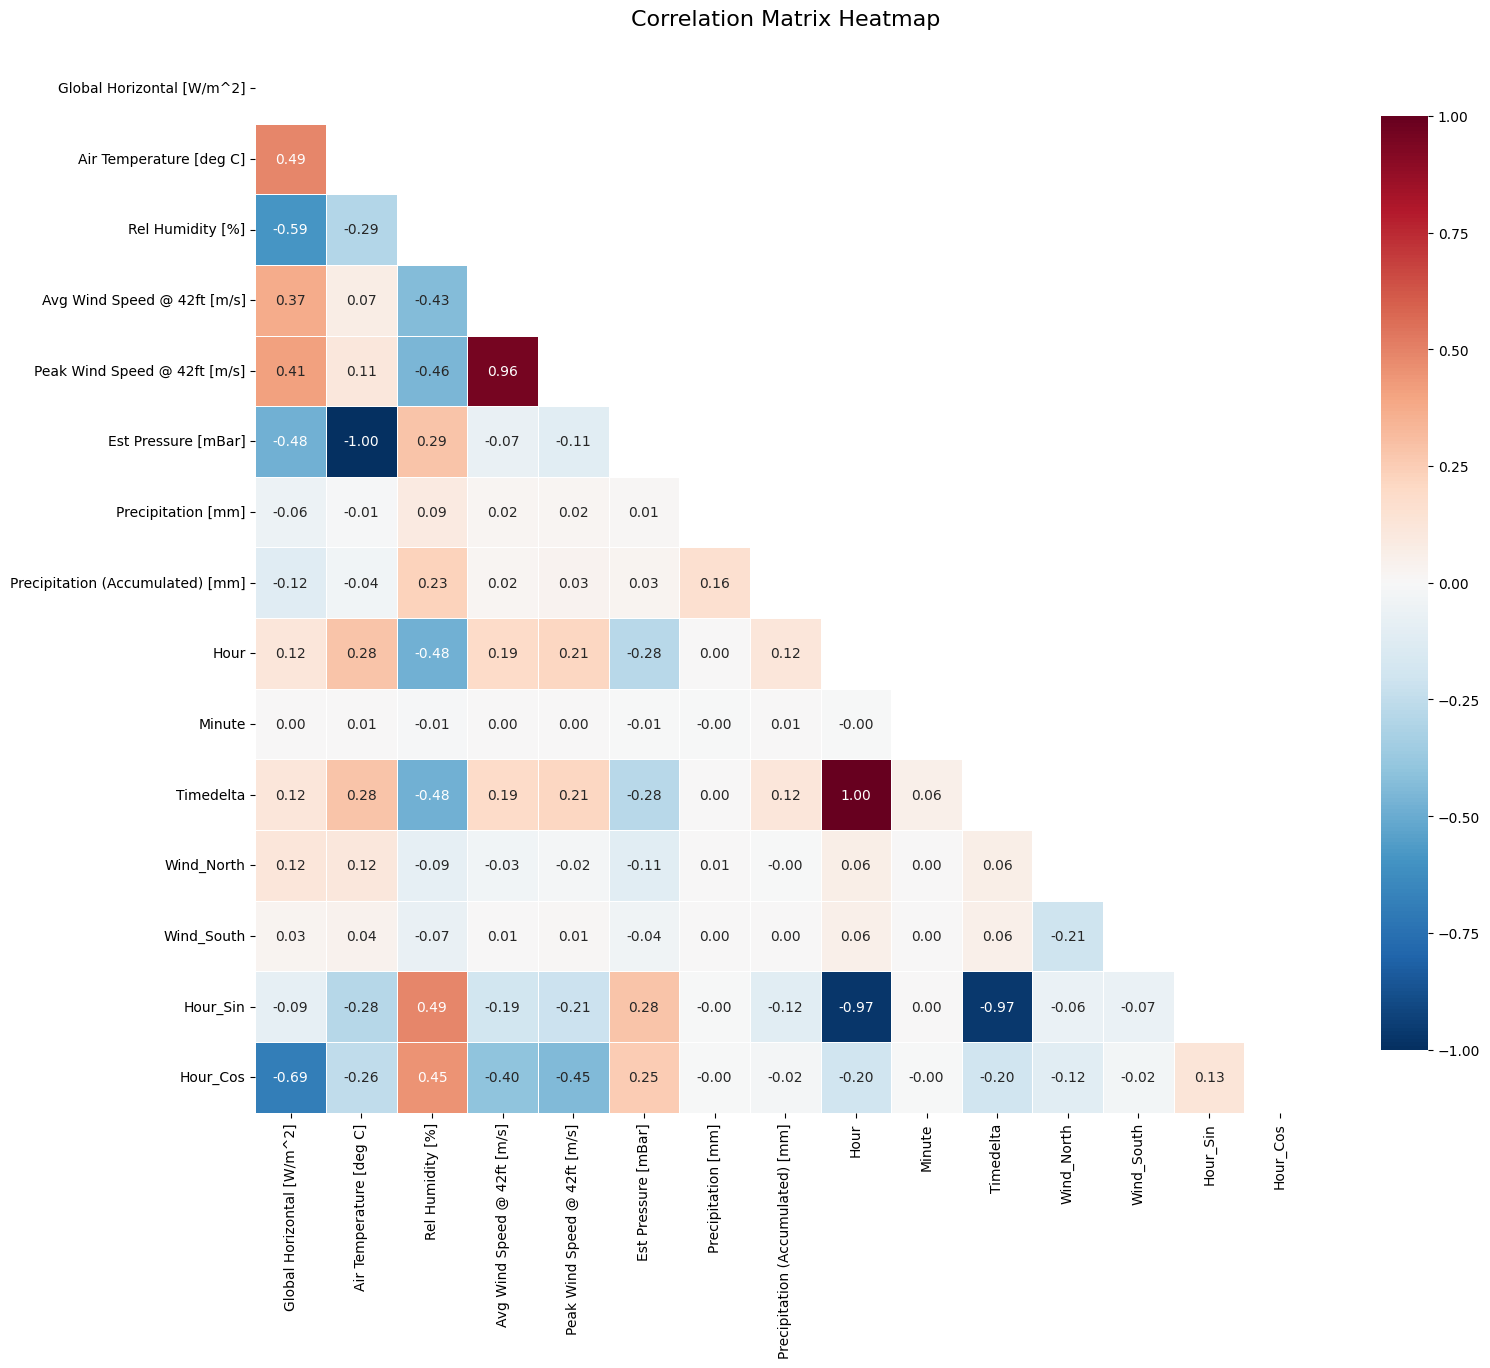


Correlations with target variable (Global Horizontal [W/m^2]):
Global Horizontal [W/m^2]           1.000000
Air Temperature [deg C]             0.489449
Peak Wind Speed @ 42ft [m/s]        0.408044
Avg Wind Speed @ 42ft [m/s]         0.371945
Wind_North                          0.123601
Hour                                0.119489
Timedelta                           0.119367
Wind_South                          0.026377
Minute                              0.001395
Precipitation [mm]                 -0.060322
Hour_Sin                           -0.091533
Precipitation (Accumulated) [mm]   -0.124680
Est Pressure [mBar]                -0.480223
Rel Humidity [%]                   -0.590090
Hour_Cos                           -0.692787
Name: Global Horizontal [W/m^2], dtype: float64

Correlations for Hour-related features:
Hour        0.119489
Hour_Sin   -0.091533
Hour_Cos   -0.692787
Name: Global Horizontal [W/m^2], dtype: float64

Shape of correlation matrix: (15, 15)

Columns used in corre

In [ ]:

# def create_correlation_matrix(df, target_column='Global Horizontal [W/m^2]'):
#     """
#     Create and visualize a correlation matrix for all features including the target variable.
#     """
#     # Select numeric columns
#     numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

#     # Add Hour, Hour_Sin, Hour_Cos if they exist
#     for col in ['Hour', 'Hour_Sin', 'Hour_Cos']:
#         if col in df.columns and col not in numeric_columns:
#             numeric_columns.append(col)

#     numeric_df = df[numeric_columns]

#     # Compute the correlation matrix
#     corr_matrix = numeric_df.corr()

#     # Create a heatmap of the correlation matrix
#     plt.figure(figsize=(16, 14))
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
#     sns.heatmap(corr_matrix,
#                 mask=mask,
#                 annot=True,
#                 fmt=".2f",
#                 cmap='RdBu_r',
#                 vmin=-1,
#                 vmax=1,
#                 center=0,
#                 square=True,
#                 linewidths=0.5,
#                 cbar_kws={"shrink": .8})

#     plt.title('Correlation Matrix Heatmap', fontsize=16, pad=20)
#     plt.tight_layout()
#     plt.show()

#     # Print correlations with the target variable
#     target_correlations = corr_matrix[target_column].sort_values(ascending=False)
#     print("\nCorrelations with target variable (Global Horizontal [W/m^2]):")
#     print(target_correlations)

#     # Print specific correlations for Hour-related features if they exist
#     hour_features = [col for col in ['Hour', 'Hour_Sin', 'Hour_Cos'] if col in corr_matrix.columns]
#     if hour_features:
#         print("\nCorrelations for Hour-related features:")
#         hour_correlations = target_correlations[hour_features]
#         print(hour_correlations)

#     return corr_matrix

# # Use the function
# corr_matrix = create_correlation_matrix(df)

# # Print the shape of the correlation matrix to verify all features are included
# print(f"\nShape of correlation matrix: {corr_matrix.shape}")

# # Print the column names used in the correlation matrix
# print("\nColumns used in correlation matrix:")
# print(corr_matrix.columns.tolist())

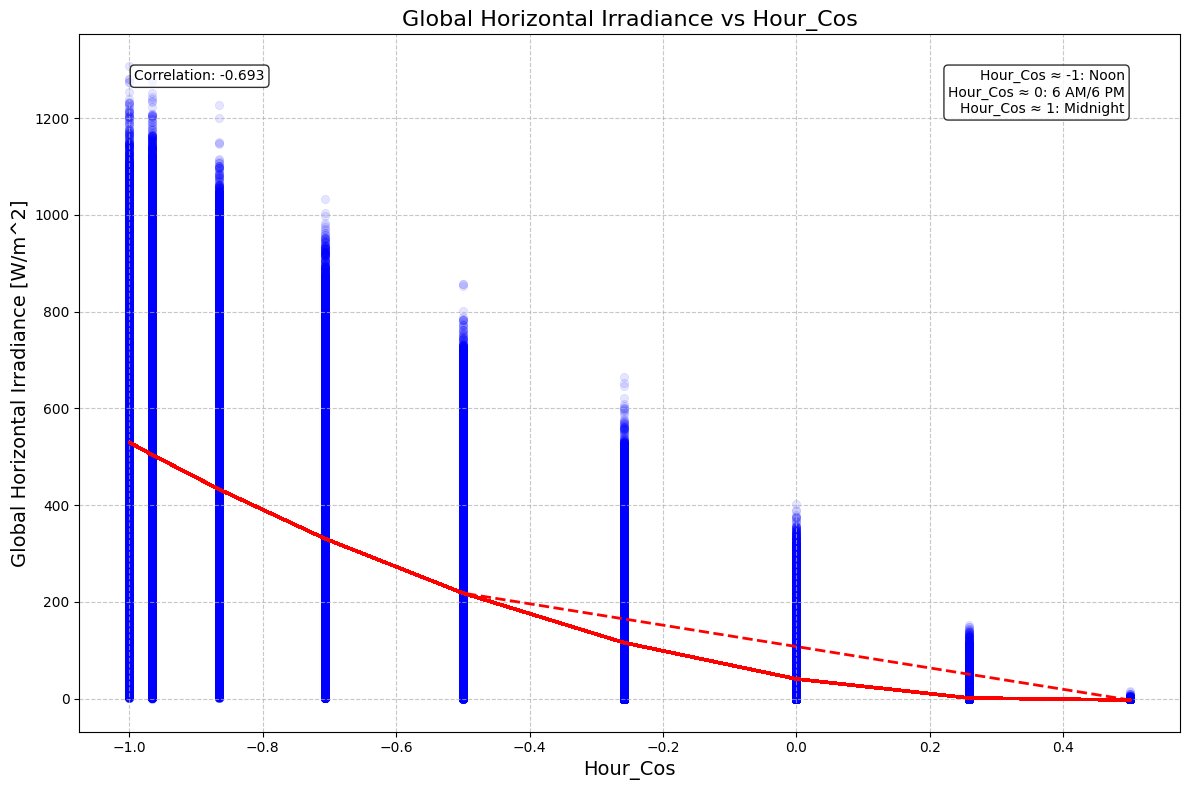

In [ ]:
# def plot_hour_cos_vs_ghi(df):
#     plt.figure(figsize=(12, 8))

#     # Create a scatter plot with color indicating point density
#     sns.scatterplot(x='Hour_Cos', y='Global Horizontal [W/m^2]', data=df,
#                     alpha=0.1, color='blue', edgecolor=None)

#     # Add a trend line using numpy's polyfit
#     z = np.polyfit(df['Hour_Cos'], df['Global Horizontal [W/m^2]'], 2)
#     p = np.poly1d(z)
#     plt.plot(df['Hour_Cos'], p(df['Hour_Cos']), "r--", linewidth=2)

#     # Customize the plot
#     plt.title('Global Horizontal Irradiance vs Hour_Cos', fontsize=16)
#     plt.xlabel('Hour_Cos', fontsize=14)
#     plt.ylabel('Global Horizontal Irradiance [W/m^2]', fontsize=14)
#     plt.grid(True, linestyle='--', alpha=0.7)

#     # Add text explaining Hour_Cos values
#     plt.text(0.95, 0.95, 'Hour_Cos ≈ -1: Noon\nHour_Cos ≈ 0: 6 AM/6 PM\nHour_Cos ≈ 1: Midnight',
#              transform=plt.gca().transAxes, verticalalignment='top',
#              horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#     # Add correlation coefficient to the plot
#     correlation = df['Hour_Cos'].corr(df['Global Horizontal [W/m^2]'])
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
#              transform=plt.gca().transAxes, verticalalignment='top',
#              horizontalalignment='left', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#     plt.tight_layout()
#     plt.show()

# # Assuming your dataframe is named 'df'
# plot_hour_cos_vs_ghi(df)

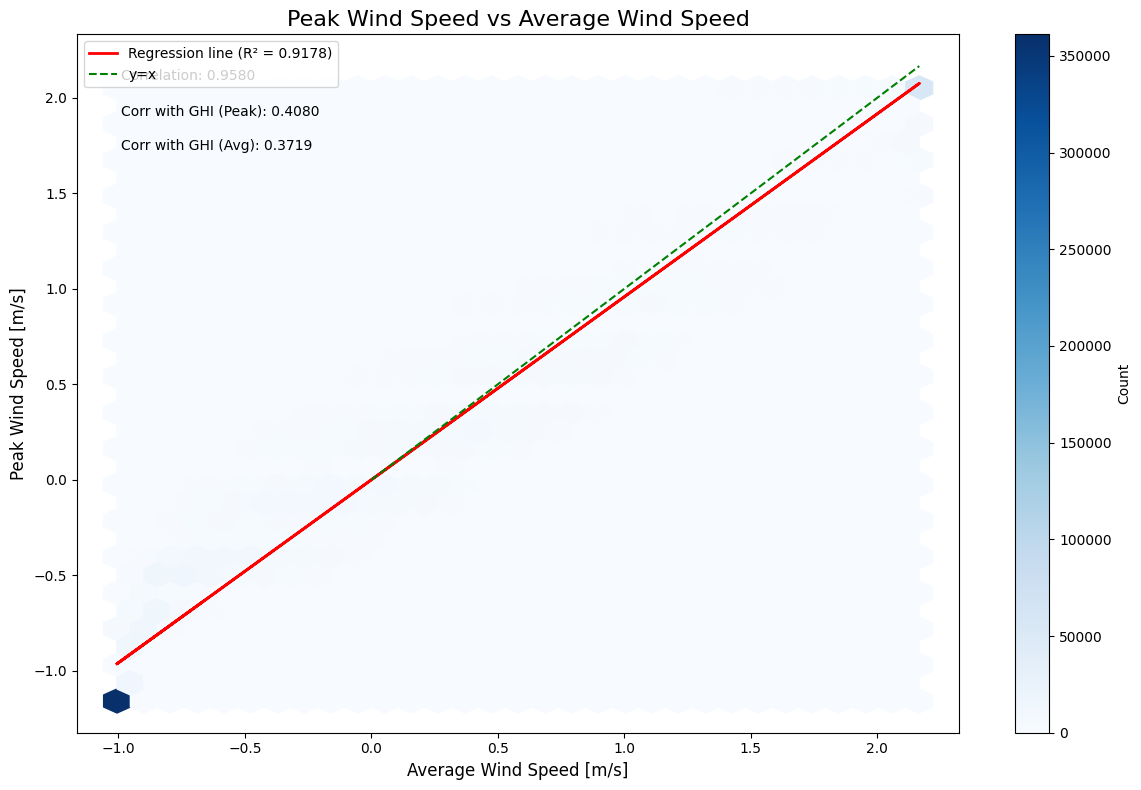

In [11]:
# from scipy import stats

# def analyze_wind_speed_correlation(df):
#     # Calculate correlation between Peak and Avg Wind Speed
#     correlation = df['Peak Wind Speed @ 42ft [m/s]'].corr(df['Avg Wind Speed @ 42ft [m/s]'])

#     # Calculate correlations with the target variable
#     target_corr = df[['Peak Wind Speed @ 42ft [m/s]', 'Avg Wind Speed @ 42ft [m/s]', 'Global Horizontal [W/m^2]']].corr()['Global Horizontal [W/m^2]']

#     # Create a scatter plot with hex bins to handle overplotting
#     plt.figure(figsize=(12, 8))

#     # Hexbin plot
#     plt.hexbin(df['Avg Wind Speed @ 42ft [m/s]'], df['Peak Wind Speed @ 42ft [m/s]'],
#                gridsize=30, cmap='Blues')

#     # Add color bar
#     cb = plt.colorbar()
#     cb.set_label('Count')

#     # Add regression line
#     x = df['Avg Wind Speed @ 42ft [m/s]']
#     y = df['Peak Wind Speed @ 42ft [m/s]']
#     slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
#     line = slope * x + intercept
#     plt.plot(x, line, color='red', lw=2, label=f'Regression line (R² = {r_value**2:.4f})')

#     # Plot settings
#     plt.title('Peak Wind Speed vs Average Wind Speed', fontsize=16)
#     plt.xlabel('Average Wind Speed [m/s]', fontsize=12)
#     plt.ylabel('Peak Wind Speed [m/s]', fontsize=12)

#     # Add diagonal line for reference
#     max_val = max(df['Peak Wind Speed @ 42ft [m/s]'].max(), df['Avg Wind Speed @ 42ft [m/s]'].max())
#     plt.plot([0, max_val], [0, max_val], 'g--', label='y=x')

#     # Add text annotations
#     plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', transform=plt.gca().transAxes,
#              fontsize=10, verticalalignment='top')
#     plt.text(0.05, 0.90, f'Corr with GHI (Peak): {target_corr["Peak Wind Speed @ 42ft [m/s]"]:.4f}',
#              transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
#     plt.text(0.05, 0.85, f'Corr with GHI (Avg): {target_corr["Avg Wind Speed @ 42ft [m/s]"]:.4f}',
#              transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Assuming your dataframe is named 'df'
# analyze_wind_speed_correlation(df)

In [ ]:
# def select_features(df):
#     # Features to definitely keep
#     features_to_keep = [
#         'Global Horizontal [W/m^2]',  # Target variable
#         'Air Temperature [deg C]',
#         'Peak Wind Speed @ 42ft [m/s]',
#         'Avg Wind Speed @ 42ft [m/s]',
#         'Est Pressure [mBar]',
#         'Rel Humidity [%]',
#         'Hour_Cos'
#     ]

#     # Features to consider keeping (we'll keep them for now, but you can experiment later)
#     features_to_consider = [
#         'Hour_Sin',
#         'Wind_North',
#         'Precipitation [mm]',
#         'Precipitation (Accumulated) [mm]',
#         ''
#     ]

#     # Combine all features we want to keep
#     all_features_to_keep = features_to_keep + features_to_consider

#     # Create a new dataframe with only the selected features
#     df_selected = df[all_features_to_keep].copy()

#     # Print information about dropped and kept features
#     print("Features dropped:")
#     print(set(df.columns) - set(all_features_to_keep))

#     print("\nFeatures kept:")
#     print(df_selected.columns.tolist())

#     print(f"\nOriginal dataframe shape: {df.shape}")
#     print(f"New dataframe shape: {df_selected.shape}")

#     return df_selected

# # Assuming your original dataframe is named 'df'
# df_selected = select_features(df)

# # If you want to save the new dataframe to a CSV file
# # df_selected.to_csv('solar_irradiance_selected_features.csv', index=False)

In [ ]:
def split_and_scale_data(df, target_column='Global Horizontal [W/m^2]'):
    """
    Split the data into train (2016-2018) and test (2019) sets,
    scale the numeric feature columns, and retain datetime information.
    """
    # Ensure the dataframe has a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['DATE (MM/DD/YYYY)'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'])
        df.set_index('DATE (MM/DD/YYYY)', inplace=True)

    # Split into features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split into train (2016-2018) and test (2019) sets
    X_train = X[X.index.year < 2019]
    X_test = X[X.index.year == 2019]
    y_train = y[y.index.year < 2019]
    y_test = y[y.index.year == 2019]

    # Initialize the scaler
    scaler = StandardScaler()

    # Separate numeric and non-numeric columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns

    # Handle timedelta columns
    for col in numeric_cols:
        if pd.api.types.is_timedelta64_dtype(X_train[col]):
            X_train[col] = X_train[col].dt.total_seconds()
            X_test[col] = X_test[col].dt.total_seconds()

    # Fit the scaler on the numeric training data
    scaler.fit(X_train[numeric_cols])

    # Transform numeric columns
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[numeric_cols]),
                                  columns=numeric_cols, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_cols]),
                                 columns=numeric_cols, index=X_test.index)

    # Add non-numeric columns back
    for col in non_numeric_cols:
        X_train_scaled[col] = X_train[col]
        X_test_scaled[col] = X_test[col]

    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Test set shape: {X_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Use the function
X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(df)

# Print column information
print("\nColumns in scaled data:")
print(X_train_scaled.columns.tolist())

# Check for any remaining issues
print("\nData types in scaled training data:")
print(X_train_scaled.dtypes)

# Verify scaling for numeric columns
numeric_cols = X_train_scaled.select_dtypes(include=[np.number]).columns
print("\nMean and standard deviation of scaled numeric features:")
print(X_train_scaled[numeric_cols].mean())
print(X_train_scaled[numeric_cols].std())

# Print information about non-numeric columns
non_numeric_cols = X_train_scaled.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns retained:")
print(non_numeric_cols.tolist())

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

def prepare_data_for_lstm(X, y):
    X = X.drop(['DATE (MM/DD/YYYY)', 'EST'], axis=1, errors='ignore')
    for col in X.columns:
        if not np.issubdtype(X[col].dtype, np.number):
            X[col] = pd.to_numeric(X[col], errors='coerce')
    X = X.select_dtypes(include=[np.number])
    return X.astype('float32'), y.astype('float32')

def downsample_data(X, y, factor):
    return X.iloc[::factor], y.iloc[::factor]

class TimeSeriesGenerator(Sequence):
    def __init__(self, X, y, time_steps, batch_size):
        self.X, self.y = X, y
        self.time_steps = time_steps
        self.batch_size = batch_size
        self.indexes = np.arange(len(X) - time_steps)

    def __len__(self):
        return (len(self.indexes) - 1) // self.batch_size + 1

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.indexes))
        X_batch = np.array([self.X.iloc[i:i+self.time_steps].values for i in self.indexes[start:end]])
        y_batch = np.array([self.y.iloc[i+self.time_steps] for i in self.indexes[start:end]])
        return X_batch, y_batch

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    return model

def train_lstm_model(X_train, X_test, y_train, y_test, time_steps, epochs=50, batch_size=32, downsample_factor=5):
    X_train, y_train = prepare_data_for_lstm(X_train, y_train)
    X_test, y_test = prepare_data_for_lstm(X_test, y_test)

    X_train, y_train = downsample_data(X_train, y_train, downsample_factor)
    X_test, y_test = downsample_data(X_test, y_test, downsample_factor)

    print(f"Downsampled training data shape: {X_train.shape}")
    print(f"Downsampled test data shape: {X_test.shape}")

    train_gen = TimeSeriesGenerator(X_train, y_train, time_steps, batch_size)
    test_gen = TimeSeriesGenerator(X_test, y_test, time_steps, batch_size)

    model = create_lstm_model((time_steps, X_train.shape[1]))

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001)
    ]

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        callbacks=callbacks,
        verbose=1
    )

    train_predictions = model.predict(train_gen)
    test_predictions = model.predict(test_gen)

    train_mse = mean_squared_error(y_train[time_steps:], train_predictions)
    test_mse = mean_squared_error(y_test[time_steps:], test_predictions)
    train_mae = mean_absolute_error(y_train[time_steps:], train_predictions)
    test_mae = mean_absolute_error(y_test[time_steps:], test_predictions)
    train_r2 = r2_score(y_train[time_steps:], train_predictions)
    test_r2 = r2_score(y_test[time_steps:], test_predictions)

    print(f"\nModel Performance (Time Steps: {time_steps}, Downsample Factor: {downsample_factor}):")
    print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
    print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss (Time Steps: {time_steps}, Downsample Factor: {downsample_factor})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    subset_size = min(1000, len(test_predictions))
    plt.figure(figsize=(16, 8))
    plt.plot(y_test[time_steps:time_steps+subset_size], label='Actual')
    plt.plot(test_predictions[:subset_size], label='Predicted')
    plt.title(f'LSTM: Actual vs Predicted GHI (Time Steps: {time_steps}, Downsample Factor: {downsample_factor})')
    plt.xlabel('Time')
    plt.ylabel('Global Horizontal Irradiance [W/m^2]')
    plt.legend()
    plt.show()

    return model, history, test_predictions

In [ ]:
# Example usage:
time_steps_to_try = [60, 180, 360]  # Reduced number of time steps to try
downsample_factor = 5  # Adjust this factor to reduce data size

for steps in time_steps_to_try:
    print(f"\nTraining model with {steps} time steps")
    model, history, predictions = train_lstm_model(X_train_scaled, X_test_scaled, y_train, y_test, steps, downsample_factor=downsample_factor)


Training model with 60 time steps
Downsampled training data shape: (210652, 14)
Downsampled test data shape: (60501, 14)
Epoch 1/50
6581/6581 [==============================] - 430s 65ms/step - loss: 106313.2109 - val_loss: 227747.0156 - lr: 0.0010
Epoch 2/50
6581/6581 [==============================] - 441s 67ms/step - loss: 84189.4766 - val_loss: 81223.8359 - lr: 0.0010
Epoch 3/50
6581/6581 [==============================] - 445s 68ms/step - loss: 79347.3672 - val_loss: 574765120.0000 - lr: 0.0010
Epoch 4/50
6581/6581 [==============================] - 447s 68ms/step - loss: 77747.6172 - val_loss: 341838.5000 - lr: 0.0010
Epoch 5/50
6581/6581 [==============================] - 430s 65ms/step - loss: 77666.8438 - val_loss: 72694.6172 - lr: 0.0010
Epoch 6/50
6581/6581 [==============================] - 442s 67ms/step - loss: 77728.8125 - val_loss: 77950.1172 - lr: 0.0010
Epoch 7/50
6581/6581 [==============================] - 450s 68ms/step - loss: 77765.3281 - val_loss: 73559.8984 - 

## MENTION THE NUMBER TO TIME STEP LSTM MODEL THAT GAVE THE BEST PREDICTION IN THE PAPER

In [ ]:
# Evaluate the model
train_mse = mean_squared_error(y_train_seq, train_predictions)
test_mse = mean_squared_error(y_test_seq, test_predictions)
train_mae = mean_absolute_error(y_train_seq, train_predictions)
test_mae = mean_absolute_error(y_test_seq, test_predictions)
train_r2 = r2_score(y_train_seq, train_predictions)
test_r2 = r2_score(y_test_seq, test_predictions)

print("\nModel Performance:")
print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual for a subset of test data
subset_size = 500  # Adjust as needed
plt.figure(figsize=(16, 8))
plt.plot(y_test_seq[:subset_size], label='Actual')
plt.plot(test_predictions[:subset_size], label='Predicted')
plt.title('LSTM: Actual vs Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance [W/m^2]')
plt.legend()
plt.show()

In [ ]:
# # Create a numeric representation of the datetime columns for training set
# X_train_scaled['DateTime_numeric'] = pd.to_numeric(X_train_scaled['DATE (MM/DD/YYYY)'])
# X_train_scaled['Hour_numeric'] = X_train_scaled['Hour'].astype(int)
# X_train_scaled['Minute_numeric'] = X_train_scaled['Minute'].astype(int)

# # Combine hours and minutes into a single numeric column
# X_train_scaled['Time_numeric'] = X_train_scaled['Hour_numeric'] * 60 + X_train_scaled['Minute_numeric']

# # Drop original datetime and time-related columns
# X_train_scaled = X_train_scaled.drop(['EST','Hour', 'Minute', 'Hour_numeric', 'Minute_numeric', 'DATE (MM/DD/YYYY)'], axis=1)


In [ ]:
# # Create a numeric representation of the datetime columns for test set
# X_test_scaled['DateTime_numeric'] = pd.to_numeric(X_test_scaled['DATE (MM/DD/YYYY)'])
# X_test_scaled['Hour_numeric'] = X_test_scaled['Hour'].astype(int)
# X_test_scaled['Minute_numeric'] = X_test_scaled['Minute'].astype(int)

# # Combine hours and minutes into a single numeric column
# X_test_scaled['Time_numeric'] = X_test_scaled['Hour_numeric'] * 60 + X_test_scaled['Minute_numeric']

# # Drop original datetime and time-related columns
# X_test_scaled = X_test_scaled.drop(['EST', 'Hour', 'Minute', 'Hour_numeric', 'Minute_numeric', 'DATE (MM/DD/YYYY)'], axis=1)

In [ ]:
def clean_column_names(df):
    def clean_name(name):
        # Remove brackets and their contents, replace spaces with underscores
        cleaned = re.sub(r'\[.*?\]', '', name).strip().replace(' ', '_')
        # Remove any remaining special characters
        cleaned = re.sub(r'[^a-zA-Z0-9_]', '', cleaned)
        return cleaned

    df.columns = [clean_name(col) for col in df.columns]
    return df


def prepare_data_for_xgboost(X_train, X_test, y_train, y_test, wind_feature='both'):
    """
    Prepare data for XGBoost model, with option to select wind speed feature.

    Parameters:
    - X_train, X_test, y_train, y_test: Input data
    - wind_feature: 'avg', 'peak', or 'both' (default)
    """
    # Create copies to avoid modifying original data
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # Clean column names
    X_train_prep = clean_column_names(X_train_prep)
    X_test_prep = clean_column_names(X_test_prep)

    # Columns to drop
    columns_to_drop = ['DATE_MMDDYYYY', 'EST']

    # Add wind speed feature to drop based on selection
    if wind_feature == 'avg':
        columns_to_drop.append('Peak_Wind_Speed_42ft_ms')
    elif wind_feature == 'peak':
        columns_to_drop.append('Avg_Wind_Speed_42ft_ms')
    # If 'both', we don't add any wind speed feature to columns_to_drop

    # Drop specified columns
    X_train_prep = X_train_prep.drop(columns=[col for col in columns_to_drop if col in X_train_prep.columns])
    X_test_prep = X_test_prep.drop(columns=[col for col in columns_to_drop if col in X_test_prep.columns])

    # Ensure all remaining columns are numeric
    X_train_prep = X_train_prep.select_dtypes(include=[np.number])
    X_test_prep = X_test_prep.select_dtypes(include=[np.number])

    return X_train_prep, X_test_prep, y_train, y_test



def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test, wind_feature='both'):
    # Prepare data
    X_train_prep, X_test_prep, y_train_prep, y_test_prep = prepare_data_for_xgboost(X_train, X_test, y_train, y_test, wind_feature)

    # Create and train the model
    model = XGBRegressor(
        colsample_bytree=1.0,
        gamma=0,
        learning_rate=0.1,
        max_depth=5,
        n_estimators=50,
        subsample=1.0
    )
    model.fit(X_train_prep, y_train_prep)

    # Make predictions
    predictions = model.predict(X_test_prep)

    # Calculate metrics
    mse = mean_squared_error(y_test_prep, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_prep, predictions)
    r2 = r2_score(y_test_prep, predictions)

    print(f"\nXGBoost Model with {wind_feature} wind speed Performance:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared Score: {r2:.4f}")

    # Plot feature importance
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(X_train_prep.columns[sorted_idx])
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'XGBoost Feature Importance with {wind_feature} wind speed')
    plt.tight_layout()
    plt.show()

    return model, predictions, rmse, mae, r2


# **Add the comparison plot to the paper**




In [ ]:
# Run models with average, peak, and both wind speeds
avg_wind_model, avg_wind_predictions, avg_rmse, avg_mae, avg_r2 = train_and_evaluate_xgboost(
    X_train_scaled, X_test_scaled, y_train, y_test, wind_feature='avg'
)

peak_wind_model, peak_wind_predictions, peak_rmse, peak_mae, peak_r2 = train_and_evaluate_xgboost(
    X_train_scaled, X_test_scaled, y_train, y_test, wind_feature='peak'
)

both_wind_model, both_wind_predictions, both_rmse, both_mae, both_r2 = train_and_evaluate_xgboost(
    X_train_scaled, X_test_scaled, y_train, y_test, wind_feature='both'
)

In [ ]:
# Compare results
print("\nComparison of Models:")
print(f"{'Metric':<25} {'Avg Wind Speed':<20} {'Peak Wind Speed':<20} {'Both Wind Speeds':<20}")
print("-" * 85)
print(f"{'RMSE':<25} {avg_rmse:<20.2f} {peak_rmse:<20.2f} {both_rmse:<20.2f}")
print(f"{'MAE':<25} {avg_mae:<20.2f} {peak_mae:<20.2f} {both_mae:<20.2f}")
print(f"{'R-squared':<25} {avg_r2:<20.4f} {peak_r2:<20.4f} {both_r2:<20.4f}")

In [ ]:
# Plot actual vs predicted for all three models
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.scatter(y_test, avg_wind_predictions, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel("Actual Values")
ax1.set_ylabel("Predicted Values")
ax1.set_title("Actual vs Predicted (Avg Wind Speed)")

ax2.scatter(y_test, peak_wind_predictions, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel("Actual Values")
ax2.set_ylabel("Predicted Values")
ax2.set_title("Actual vs Predicted (Peak Wind Speed)")

ax3.scatter(y_test, both_wind_predictions, alpha=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel("Actual Values")
ax3.set_ylabel("Predicted Values")
ax3.set_title("Actual vs Predicted (Both Wind Speeds)")

plt.tight_layout()
plt.show()

# PLOT THE DIFFERENT PREDICTIONS OF EACH MODEL ON THE SAME PLOT FOR COMPARISON(INSTEAD OF INDIVIDUALLY)